# RS2OSM
# Transfer Building Heights Extracted By Remote Sensing to OSM Data

Written by: Sasanka Madawalagama
Version: 0.2


In [1]:
# Imports
# -----------------------------------

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

In [2]:
# Functions
# -----------------------------------

def hausdorff_distance(polygon1, polygon2):
    """
    Compute the Hausdorff distance between two Shapely polygons.
    :param polygon1:
    :param polygon2:
    :return:
    """

    # Compute distances from each point in polygon1 to polygon2
    distances1 = [polygon1.distance(Point(p)) for p in polygon2.exterior.coords]

    # Compute distances from each point in polygon2 to polygon1
    distances2 = [polygon2.distance(Point(p)) for p in polygon1.exterior.coords]

    # Compute Hausdorff distance
    hausdorff_distance = max([max(distances1), max(distances2)])

    return hausdorff_distance

In [3]:
# Parameters
# -----------------------------------

# Data Paths
osm_path = r'./data/berlin_osm.gpkg'
rs_path = r'./data/ALKIS_cadastre_Berlin_TestArea.shp'
# CRS
epsg_code = 32633

In [8]:
# Read Geodata and Pre-Process
# -----------------------------------

# Required fields to read
osm_fields = ['full_id', 'osm_id', 'geometry']
rs_fields = ['geometry']

# Loading data to geopandas df, setting up the CRS
osm_bldgs = gpd.read_file(osm_path)[osm_fields].set_crs(epsg=epsg_code, allow_override=True)
# rs_bldgs = gpd.read_file(rs_path).set_crs(epsg=epsg_code, allow_override=True).reset_index()
rs_bldgs = gpd.read_file(rs_path)[rs_fields].set_crs(epsg=epsg_code, allow_override=True).reset_index()
rs_bldgs = rs_bldgs.rename(columns={'index': 'rs_id'})

# Convert multipolygon to polygon
# index_parts=false --> If True, the resulting index will be a multi-index (original index with an additional level indicating the multiple geometries: a new zero-based index for each single part geometry per multi-part geometry)
osm_bldgs = osm_bldgs.explode(index_parts=False)
rs_bldgs = rs_bldgs.explode(index_parts=False)

# Calculate area
osm_bldgs['osm_bld_area'] = osm_bldgs.geometry.area
rs_bldgs['rs_bld_area'] = rs_bldgs.geometry.area

In [22]:
# Visualize the Data
# -----------------------------------

# fig, ax = plt.subplots(figsize=(25,25))
# osm_bldgs.plot(ax=ax, color='green', edgecolor='black', linewidth=1, alpha=1)
# rs_bldgs.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
# plt.show()

print('-'*20, '\n')
print('OSM Data')
display(osm_bldgs)

print('-'*20, '\n')
print('RS Extracted Data')
display(rs_bldgs)

-------------------- 

OSM Data


,full_id,osm_id,geometry,osm_bld_area
0,r85531,85531,"POLYGON ((388494.577 5817090.065, 388499.257 5...",6059.041467
1,r145107,145107,"POLYGON ((388111.189 5816426.647, 388082.238 5...",790.034314
2,r145108,145108,"POLYGON ((388196.872 5816315.573, 388192.920 5...",1636.301174
3,r1526193,1526193,"POLYGON ((388370.569 5816248.944, 388378.386 5...",377.033157
4,r1526194,1526194,"POLYGON ((388362.872 5816258.177, 388358.686 5...",874.263518
...,...,...,...,...
1999,w1112513246,1112513246,"POLYGON ((388715.769 5817241.562, 388717.540 5...",8.301753
2000,w1112513250,1112513250,"POLYGON ((388741.404 5817242.549, 388743.207 5...",7.462146
2001,w1115480259,1115480259,"POLYGON ((388726.099 5816387.104, 388727.715 5...",33.697212
2002,w1130573145,1130573145,"POLYGON ((387650.558 5816765.663, 387671.543 5...",449.911326


-------------------- 

RS Extracted Data


,rs_id,geometry,rs_bld_area
0,0,"POLYGON ((388304.913 5817003.195, 388304.555 5...",69.993374
1,1,"POLYGON ((388481.327 5816006.722, 388478.706 5...",11.478470
2,2,"POLYGON ((388486.124 5815999.936, 388483.738 5...",25.010182
3,3,"POLYGON ((389070.499 5816417.257, 389068.889 5...",853.388349
4,4,"POLYGON ((388689.686 5816444.160, 388686.426 5...",27.134120
...,...,...,...
1834,1834,"POLYGON ((387598.583 5816554.310, 387598.648 5...",659.653569
1835,1835,"POLYGON ((388186.572 5816162.788, 388189.168 5...",285.270885
1836,1836,"POLYGON ((388632.178 5816568.495, 388636.370 5...",233.499395
1837,1837,"POLYGON ((388847.497 5816161.816, 388845.012 5...",312.177769


In [10]:
# Overlay Analysis
# -----------------------------------

# Intersection of OSM data and RS data
overlayed = gpd.overlay(osm_bldgs, rs_bldgs, how='intersection')
overlayed['propo_intsct_area'] = np.round(overlayed.geometry.area/overlayed['osm_bld_area'], 3)

# Get the polygon / osm id of the polygon, corresponding to the largest intersecting area
gp = overlayed.groupby(by='full_id')['propo_intsct_area'].idxmax()
osm_rsid_relaton = overlayed.loc[gp]
osm_rsid_relaton = osm_rsid_relaton[['full_id', 'rs_id', 'propo_intsct_area']].set_index('full_id')

# Calculate Hausdorff distance
for idx, row in osm_rsid_relaton.iterrows():
    osm_idx = idx
    rs_idx = row.rs_id

    osm_poly = osm_bldgs[osm_bldgs['full_id']==osm_idx].geometry.squeeze()
    rs_poly = rs_bldgs[rs_bldgs['rs_id']==rs_idx].geometry.squeeze()

    h_dist = hausdorff_distance(osm_poly, rs_poly)
    osm_rsid_relaton.loc[idx, 'h_dist'] = h_dist

    print('OSM id: ', osm_idx, ' | Corresponding RS id: ', int(rs_idx))
    print('Hausdorff distance: ', h_dist)
    print('-'*20)


temp = osm_rsid_relaton.reset_index()
merged = osm_bldgs.merge(temp, on='full_id', how='left')

print(merged.head())

/Users/sasankamadawalagama/miniforge3/envs/osmsim/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


OSM id:  r13132134  | Corresponding RS id:  1641
Hausdorff distance:  0.3945155842442111
--------------------
OSM id:  r145107  | Corresponding RS id:  852
Hausdorff distance:  0.11459362848520767
--------------------
OSM id:  r145108  | Corresponding RS id:  516
Hausdorff distance:  6.270804848090911
--------------------
OSM id:  r14743467  | Corresponding RS id:  1049
Hausdorff distance:  0.026905226703963715
--------------------
OSM id:  r1526193  | Corresponding RS id:  1510
Hausdorff distance:  0.021823448944214528
--------------------
OSM id:  r1526194  | Corresponding RS id:  1259
Hausdorff distance:  0.041464569691381965
--------------------
OSM id:  r1660342  | Corresponding RS id:  574
Hausdorff distance:  0.02763061414106158
--------------------
OSM id:  r1872342  | Corresponding RS id:  447
Hausdorff distance:  0.027770504398249764
--------------------
OSM id:  r1967419  | Corresponding RS id:  867
Hausdorff distance:  8.650788294220058
--------------------
OSM id:  r196742

In [11]:
# Filter Outputs
# -----------------------------------

# Threshold limits
lim_intsct_area = 0.8
lim_hausdorff_dist = 3

con = np.logical_and(merged.propo_intsct_area >= lim_intsct_area,
                     merged.h_dist <= lim_hausdorff_dist)
osm_bldgs_wt_ht = merged[con]

display(osm_bldgs_wt_ht)

,full_id,osm_id,geometry,osm_bld_area,rs_id,propo_intsct_area,h_dist
0,r85531,85531,"POLYGON ((388494.577 5817090.065, 388499.257 5...",6059.041467,1560.0,0.993,1.223380
1,r145107,145107,"POLYGON ((388111.189 5816426.647, 388082.238 5...",790.034314,852.0,0.999,0.114594
3,r1526193,1526193,"POLYGON ((388370.569 5816248.944, 388378.386 5...",377.033157,1510.0,0.997,0.021823
4,r1526194,1526194,"POLYGON ((388362.872 5816258.177, 388358.686 5...",874.263518,1259.0,0.999,0.041465
5,r1660342,1660342,"POLYGON ((388641.754 5816708.898, 388658.256 5...",738.253244,574.0,0.998,0.027631
...,...,...,...,...,...,...,...
1990,w1105033259,1105033259,"POLYGON ((387554.481 5817268.497, 387554.340 5...",46.621344,425.0,0.942,0.226049
1991,w1105033260,1105033260,"POLYGON ((387558.073 5817182.863, 387564.192 5...",61.669317,118.0,0.994,0.165261
1992,w1107982242,1107982242,"POLYGON ((387686.040 5816441.686, 387688.721 5...",559.518496,216.0,0.965,2.914441
1994,w1111888404,1111888404,"POLYGON ((388170.882 5816377.858, 388169.679 5...",866.119813,53.0,0.978,1.138652


In [14]:
# Save outputs
# -----------------------------------

out_df = osm_bldgs_wt_ht[['osm_id', 'HEIGHT', 'geometry', 'h_dist']]
out_df.to_file('./outputs/berlin_osm_w_ht_hdist.shp')

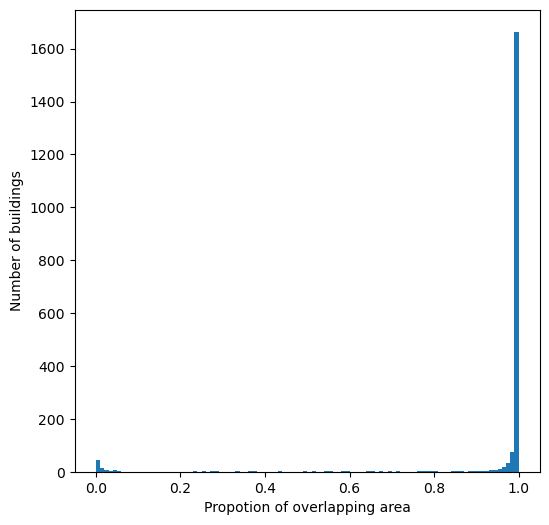

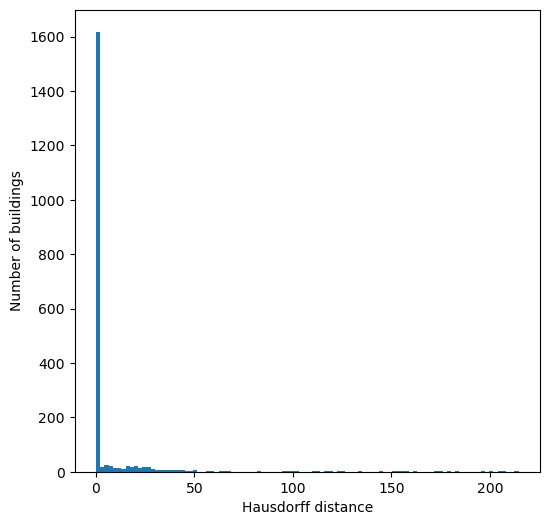

In [21]:
fig, axes = plt.subplots(figsize=(6,6))
plt.hist(x=merged.propo_intsct_area, bins=100)
plt.xlabel('Propotion of overlapping area')
plt.ylabel('Number of buildings')
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
plt.hist(x=merged.h_dist, bins=100)
plt.xlabel('Hausdorff distance')
plt.ylabel('Number of buildings')
plt.show()